In [ ]:
import pandas as pd

### 볼린저밴드
1. 데이터 20개의 평균 값 새로운 파생변수(이동평균선)
2. 상단 밴드 -> (이동 평균선 + 2 * 표준편차)
3. 하단 밴드 -> (이동 평균선 - 2 * 표준편차)
4. 과거의 데이터를 가지고 테스트
5. 이윤이 얼마나 되는지 확인

In [ ]:
df = pd.read_csv("../csv/AAPL.csv", index_col="Date")
df.head()

In [ ]:
price_df = df.loc[:, ["Adj Close"]]
price_df.head()

In [ ]:
price_df2 = df[["Adj Close"]]
price_df2.head()

In [8]:
## 이동 평균선 생성
## 20개의 데이터를 기준으로 평균을 구한 값
price_df["center"] = price_df["Adj Close"].rolling(20).mean()

In [9]:
## 상단 밴드, 하단 밴드 컬럼을 추가 
## 표준편차는 std()
## 상단 밴드 : ub (이동평균선 + 2 * 표준편차(20개기준))
## 하단 밴드 : lb (이동평균선 - 2 * 표준편차(20개기준))
price_df["ub"] = price_df["center"] + 2 * price_df["Adj Close"].rolling(20).std()
price_df["lb"] = price_df["center"] - 2 * price_df["Adj Close"].rolling(20).std()


In [11]:
price_df.iloc[18:25]

,Adj Close,center,ub,lb
Date,,,,
1981-01-09,0.455147,NaN,NaN,NaN
1981-01-12,0.451577,0.443278,0.536950,0.349605
1981-01-13,0.435513,0.444527,0.537019,0.352035
1981-01-14,0.437298,0.446937,0.535789,0.358084
1981-01-15,0.446223,0.451220,0.530255,0.372186
1981-01-16,0.442653,0.454879,0.524151,0.385608
1981-01-19,0.469426,0.459342,0.519213,0.399470


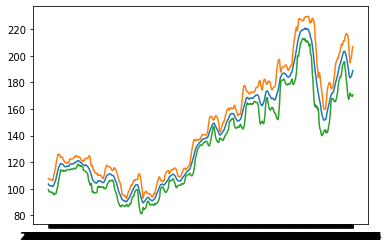

In [13]:
## 데이터를 2005-01-01 부터 최근까지 
## 라인그래프 
## 이동평균선, 업밴드, 로우밴드
## 하나의 plot 출력
import matplotlib.pyplot as plt
price_df2 = price_df.loc["2015-01-01":,]
plt.plot(price_df2["center"])
plt.plot(price_df2["ub"])
plt.plot(price_df2["lb"])
plt.show()

In [ ]:
price_df.head()

In [15]:
## 파생변수 trade 값은 ""
## trade 컬럼은 구매를 언제 하고 판매를 언제 할것인지를 삽입
price_df["trade"] = ""

> 구매조건
- 상단 밴드보다 높은 경우
    - 내 상태가 구매 상태인 경우
        - 매도 trade = ""
    - 상태가 구매가 아닌 경우
        - 아무런 행동도 하지 않는다. trade = ""
- 하단 밴드보다 낮은 경우
    - 상태가 구매 상태인 경우
        - 구매 상태를 유지 trade = "buy"
    - 상태가 구매가 아닌 경우
        - 매수 trade = "buy"
- 종가가 상단 밴드와 하단 밴드 사이에 있는 경우
    - 상태가 구매 상태인 경우
        - 구매 상태를 유지 trade = "buy"
    - 상태가 구매 상태가 아닌 경우
        - 상태를 유지 trade = ""

In [16]:
for i in price_df.index:
    # 상단 밴드보다 종가가 높은 경우
    if price_df.loc[i, "Adj Close"] > price_df.loc[i, "ub"]:
        price_df.loc[i, "trade"] = ""
    # 하단 밴드보다 종가가 낮은 경우
    elif price_df.loc[i, "Adj Close"] < price_df.loc[i, "lb"]:
        price_df.loc[i, "trade"] = "buy"
    else:
        # 구매 상태인 경우
        if price_df.shift(1).loc[i, "trade"] == "buy":
            price_df.loc[i, "trade"] = "buy"
        else:
            price_df.loc[i, "trade"] = ""


In [17]:
price_df.value_counts("trade")

trade
       2365
buy    1278
dtype: int64

In [18]:
## 수익 계산
rtn = 1.0
price_df["return"] = 1
buy = 0.0
sell = 0.0

for i in price_df.index:
    # 구매하는 경우 -> 현재의 데이터는 buy이고 바로 위 과거의 데이터는 ""
    if price_df.loc[i, "trade"] == "buy" and \
        price_df.shift(1).loc[i, "trade"] == "":
        buy = price_df.loc[i, "Adj Close"]
        print("진입일 : ", i, "진입 가격 : ", buy)
    # 판매하는 경우 -> 현재의 데이터는 ""이고 바로 위 과거 데이터는 buy
    elif price_df.loc[i, "trade"] == "" and \
        price_df.shift(1).loc[i, "trade"] == "buy":
        sell = price_df.loc[i, "Adj Close"]
        rtn = (sell - buy) / buy + 1  #손익 계산
        price_df.loc[i, "return"] = rtn
        print("판매일 : ", i, "판매 가격 : ", sell, "진입 가격 : ", buy, 
        "return : ", round(rtn, 4))

    if price_df.loc[i, "trade"] == "":
        buy = 0.0
        sell = 0.0

진입일 :  2005-04-14 진입 가격 :  4.662978
판매일 :  2005-05-23 판매 가격 :  4.975845 진입 가격 :  4.662978 return :  1.0671
진입일 :  2005-10-12 진입 가격 :  6.163489
판매일 :  2005-11-03 판매 가격 :  7.740342999999999 진입 가격 :  6.163489 return :  1.2558
진입일 :  2006-05-18 진입 가격 :  7.906785
판매일 :  2006-07-31 판매 가격 :  8.50499 진입 가격 :  7.906785 return :  1.0757
진입일 :  2006-12-21 진입 가격 :  10.37469
판매일 :  2007-01-09 판매 가격 :  11.584859 진입 가격 :  10.37469 return :  1.1166
진입일 :  2007-08-09 진입 가격 :  15.817325
판매일 :  2007-09-04 판매 가격 :  18.041189000000003 진입 가격 :  15.817325 return :  1.1406
진입일 :  2007-11-12 진입 가격 :  19.242604999999998
판매일 :  2008-03-18 판매 가격 :  16.622023000000002 진입 가격 :  19.242604999999998 return :  0.8638
진입일 :  2008-06-12 진입 가격 :  21.682976
판매일 :  2008-08-13 판매 가격 :  22.438858 진입 가격 :  21.682976 return :  1.0349
진입일 :  2008-09-04 진입 가격 :  20.176205
판매일 :  2008-10-30 판매 가격 :  13.896326 진입 가격 :  20.176205 return :  0.6887
진입일 :  2008-12-22 진입 가격 :  10.730103999999999
판매일 :  2009-02-06 판매 가격 :  12.479661 진입 가

In [19]:
# 누적 수익율
acc_rtn = 1.0
for i in price_df.index:
    rtn = price_df.loc[i, "return"]
    acc_rtn *= rtn
    price_df["acc_rtn"] = acc_rtn

print("누적 수익율 : ", acc_rtn)

누적 수익율 :  2.025088983580643
